# Time_Series_Analysis_of_the_Flow_of_Orders

## *Table of content*
1. **Introduction**
2. **Data**
    * 2.1 Data Loading
    * 2.2 Overall statistics
    * 2.3 Select features to build the model
3. **Exploratory Data Analysis of Selected Feature**
4. **Model Building**
    * 4.1 Prophet
    * 4.2 LSTM
5. **Make Predictions on Test Dataset**
    * 5.1 Predictions of Prophet
    * 5.2 Predictions of LSTM
6. **Result Comparison and Discussion**

## 1. Introduction

In this analysis work, we are working with data from **Wolt app**. Intake data is available from [here]("https://raw.githubusercontent.com/xia030520/application-assignment/main/orders_autumn_2020%5B1%5D.csv"). In this work, I focus on the time series analysis,considering the flow of orders as a process fluctuating in time.

From my point of view, time serie models can be simply divided into two classes, one class is Times Series Statistical Model(SM),and another calss is Time Series Supervised Learning Model(SLM). In this analysis, two models are considered in the time series analysis--**Prophet** from SM, and **LSTM** from SLM.

**Prophet** can deal problems related to weekly or yearly change, trend and holidays. Under this solution, time series can be decomposed into trend g(t), seasonality s(t) and holiday h(t). It is suitable to fit the flow of orders.

**LSTM network** is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem. It can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.

## **2. Data** 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.core.pylabtools import figsize
from pandas import DataFrame

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#from statsmodels.tsa.statespace.sarimax import SARIMAX
#%matplotlib inline
#from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
#from statsmodels.tsa.stattools import adfuller as ADF
#from statsmodels.stats.diagnostic import acorr_ljungbox
#import statsmodels.api as sm
#from statsmodels.graphics.api import qqplot
#from statsmodels.tsa.arima_model import ARIMA

### 2.1  Data loading

In [32]:
df_initial = pd.read_csv("https://raw.githubusercontent.com/xia030520/application-assignment/main/orders_autumn_2020%5B1%5D.csv")

print('The shape of the dataset is:', df_initial.shape)

The shape of the dataset is: (18706, 13)


### 2.2 Overall statistics

Looking at number of rows, columns and some simple statistics of the dataset.

In [7]:
# Print the first five rows
df_initial.head()

,TIMESTAMP,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION
0,2020-08-01 06:07:00.000,-19,1,60.158,24.946,60.160,24.946,29,10,0.0,15.0,3.53644,0.0
1,2020-08-01 06:17:00.000,-7,8,60.163,24.927,60.153,24.910,39,32,0.0,15.0,3.53644,0.0
2,2020-08-01 06:54:00.000,-17,4,60.161,24.937,60.162,24.939,23,6,0.0,15.0,3.53644,0.0
3,2020-08-01 07:09:00.000,-2,3,60.185,24.954,60.190,24.911,28,26,0.0,16.7,3.52267,0.0
4,2020-08-01 07:10:00.000,-1,2,60.182,24.955,60.178,24.949,27,26,0.0,16.7,3.52267,0.0


In [9]:
# Check the data types and non-null values for each column
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18706 entries, 0 to 18705
Data columns (total 13 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   TIMESTAMP                                             18706 non-null  object 
 1   ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES  18706 non-null  int64  
 2   ITEM_COUNT                                            18706 non-null  int64  
 3   USER_LAT                                              18706 non-null  float64
 4   USER_LONG                                             18706 non-null  float64
 5   VENUE_LAT                                             18706 non-null  float64
 6   VENUE_LONG                                            18706 non-null  float64
 7   ESTIMATED_DELIVERY_MINUTES                            18706 non-null  int64  
 8   ACTUAL_DELIVERY_MINUTES                               18

We can see that the variables of "CLOUD-COVERAGE", "TEMPERATIRE' and "WIND_SPEED" have missing values.

In [10]:
# Printing basicstatistics for numerical columns
df_initial.describe()

,ACTUAL_DELIVERY_MINUTES - ESTIMATED_DELIVERY_MINUTES,ITEM_COUNT,USER_LAT,USER_LONG,VENUE_LAT,VENUE_LONG,ESTIMATED_DELIVERY_MINUTES,ACTUAL_DELIVERY_MINUTES,CLOUD_COVERAGE,TEMPERATURE,WIND_SPEED,PRECIPITATION
count,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18706.000000,18429.000000,18429.000000,18429.000000,18706.000000
mean,-1.201058,2.688228,60.175234,24.941244,60.175643,24.941214,33.809313,32.608254,11.996853,16.973536,3.790991,0.332756
std,8.979834,1.886455,0.012674,0.016540,0.011509,0.014482,7.340283,10.018879,23.812605,3.411900,1.456017,1.129234
min,-41.000000,1.000000,60.153000,24.909000,60.149000,24.878000,10.000000,6.000000,0.000000,6.100000,0.077419,0.000000
25%,-7.000000,1.000000,60.163000,24.926000,60.167000,24.930000,28.000000,25.000000,0.000000,14.400000,2.696190,0.000000
50%,-2.000000,2.000000,60.175000,24.943000,60.170000,24.941000,33.000000,32.000000,0.000000,16.700000,3.631970,0.000000
75%,5.000000,4.000000,60.186000,24.954000,60.186000,24.950000,38.000000,40.000000,25.000000,18.900000,4.692530,0.000000
max,34.000000,11.000000,60.201000,24.980000,60.219000,25.042000,82.000000,58.000000,100.000000,26.700000,9.857300,6.315790


### 2.3 Select features to build the model

Considering the task is to conduct time series analysis on the daily orders, only feature of "TIMESTAMP" is used to finish the calculation. The number of orders per day from 2020/08/08 to 2020/09/30 is calculated in this section.

In [11]:
df_select=pd.DataFrame(df_initial, columns=['TIMESTAMP','TEMPERATURE'])
df_select['TIMESTAMP'] = pd.to_datetime(df_select['TIMESTAMP'])
df_select['TIMESTAMP'] = df_select['TIMESTAMP'].dt.date
df_select
c = np.ones(df_select.shape[0]).transpose()
df_select_ones= df_select.copy()
df_select_ones['ONES'] = c
df1=df_select_ones.groupby(['TIMESTAMP'])['TEMPERATURE','ONES'].sum().sort_values(['TIMESTAMP']).reset_index()
df = pd.DataFrame({
        'TIMESTAMP': df1.TIMESTAMP,
        'DAILY_ORDERS': df1.ONES,
    })
df

D:\ana\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,TIMESTAMP,DAILY_ORDERS
0,2020-08-01,299.0
1,2020-08-02,328.0
2,2020-08-03,226.0
3,2020-08-04,228.0
4,2020-08-05,256.0
...,...,...
56,2020-09-26,364.0
57,2020-09-27,386.0
58,2020-09-28,284.0
59,2020-09-29,260.0


## 3. Exporatory data analysis of selected feature

In [12]:
# Data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TIMESTAMP     61 non-null     object 
 1   DAILY_ORDERS  61 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


In [14]:
# Basic statistics
df.describe()

,DAILY_ORDERS
count,61.000000
mean,306.655738
std,58.949381
min,194.000000
25%,267.000000
50%,294.000000
75%,346.000000
max,460.000000


* We can see that the average daily orders fro August and Semptember is 306.66.

<AxesSubplot:ylabel='Frequency'>

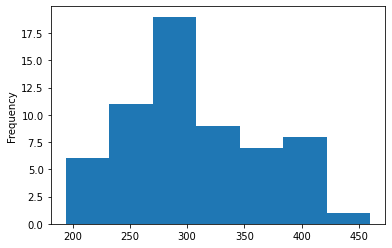

In [15]:
# Histogram od daily orders
df['DAILY_ORDERS'].plot.hist(bins=7)

In [16]:
# Number of values in each bins
print('DAILY_ORDERS')
print(df['DAILY_ORDERS'].value_counts(bins=7, sort=False))
plt.show()

DAILY_ORDERS
(193.733, 232.0]     6
(232.0, 270.0]      11
(270.0, 308.0]      19
(308.0, 346.0]      10
(346.0, 384.0]       6
(384.0, 422.0]       8
(422.0, 460.0]       1
Name: DAILY_ORDERS, dtype: int64


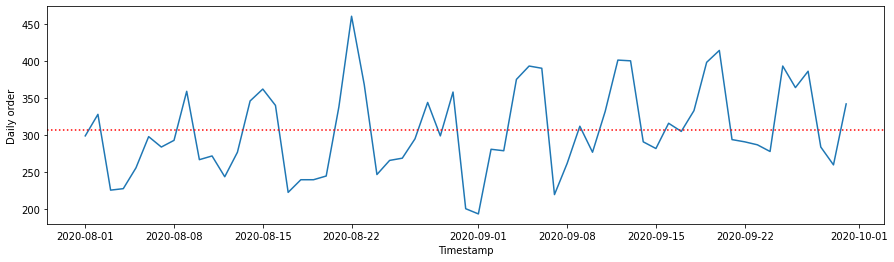

In [31]:
# Time series plot
plt.plot(df['TIMESTAMP'],df['DAILY_ORDERS'])
plt.xlabel('Timestamp')
plt.ylabel('Daily order')
plt.axhline(y=np.mean(df['DAILY_ORDERS']), linestyle=":",color='red')
figsize(20,4)

 The red dashed line is the average value of daily orders in 61 days.From the plot, we can see seasonal changes in the weekly orders and the valus of orders of each day goes around the average value.

## **4. Model Bulding** 

### 4.1  Prophet

Prophet is a suitable model for forecasting time series data. In the real application, it can fit with yearly, weekly, and daily seasonality, plus holiday effects well by adding an additive model for non-linear trend.

In [1012]:
def prophet(data: pd.DataFrame) -> pd.DataFrame:
 
    subset = pd.DataFrame({
        'ds': df_subset.TIMESTAMP,
        'y': df_subset.DAILY_ORDERS,
    })

    m = Prophet(
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=False,
        growth='linear',
    )
    
    m.add_country_holidays(country_name='FI')
    
    m.fit(subset)

    future = m.make_future_dataframe(periods=7, freq='D')

    forecast = m.predict(future)
    
    fig1 = m.plot(forecast)
    
    return forecast

### 4.2  LSTM

The Long Short-Term Memory network, or LSTM network, is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem.

It can be used to create large recurrent networks that in turn can be used to address difficult sequence problems in machine learning and achieve state-of-the-art results.

In [1027]:
n_in = 7 # hostorical quantities, 7 days used
n_out = 7 # prediction quantity, to predict 7 day
n_features = 1
n_val = 1
n_epochs = 300

In [1014]:
#train data and validation data
def split_data(x, y, n_test: int):
    
    x_train = x[:-n_val-n_out+1]
    x_val = x[-n_val:]
    y_train = y[:-n_val-n_out+1]
    y_val = y[-n_val:]
    
    return x_train, y_train, x_val, y_val

In [1015]:
#Split
def build_train(train, n_in, n_out):
    
    train = train.drop(["TIMESTAMP"], axis=1)
    X_train, Y_train = [], []
    for i in range(train.shape[0]-n_in-n_out+1):
        X_train.append(np.array(train.iloc[i:i+n_in]))
        Y_train.append(np.array(train.iloc[i+n_in:i+n_in+n_out]["DAILY_ORDERS"]))
        
    return np.array(X_train), np.array(Y_train)

In [1016]:
def build_lstm(n_in: int, n_features: int):
    
    model = Sequential()
    model.add(LSTM(12, activation='relu', input_shape=(n_in, n_features)))
    model.add(Dropout(0.111))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mae')
    
    return model

In [1017]:
#model fitting
def model_fit(x_train, y_train, x_val, y_val, n_features):
    
    model = build_lstm(
        n_in   = n_in,
        n_features= 1
    )
    model.compile(loss='mae', optimizer='adam')
    model.fit(x_train, y_train, epochs=n_epochs, batch_size=34, verbose=1,  validation_data=(x_val, y_val))
    m = model.evaluate(x_val, y_val)
    #validation_data
    print(m)
    
    return model

## 5. Make predictions on the test dataset

The test data set is composed of last 7 days of September, which is from 25th to 31th. 

### 5.1 Pedictions of Prophet

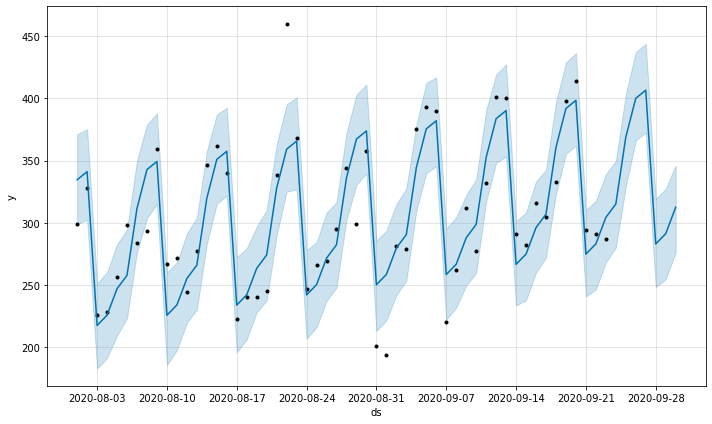

In [1018]:
# Fitting with training dataset
df_subset= df.truncate(after  = '53')
result = prophet(df_subset)

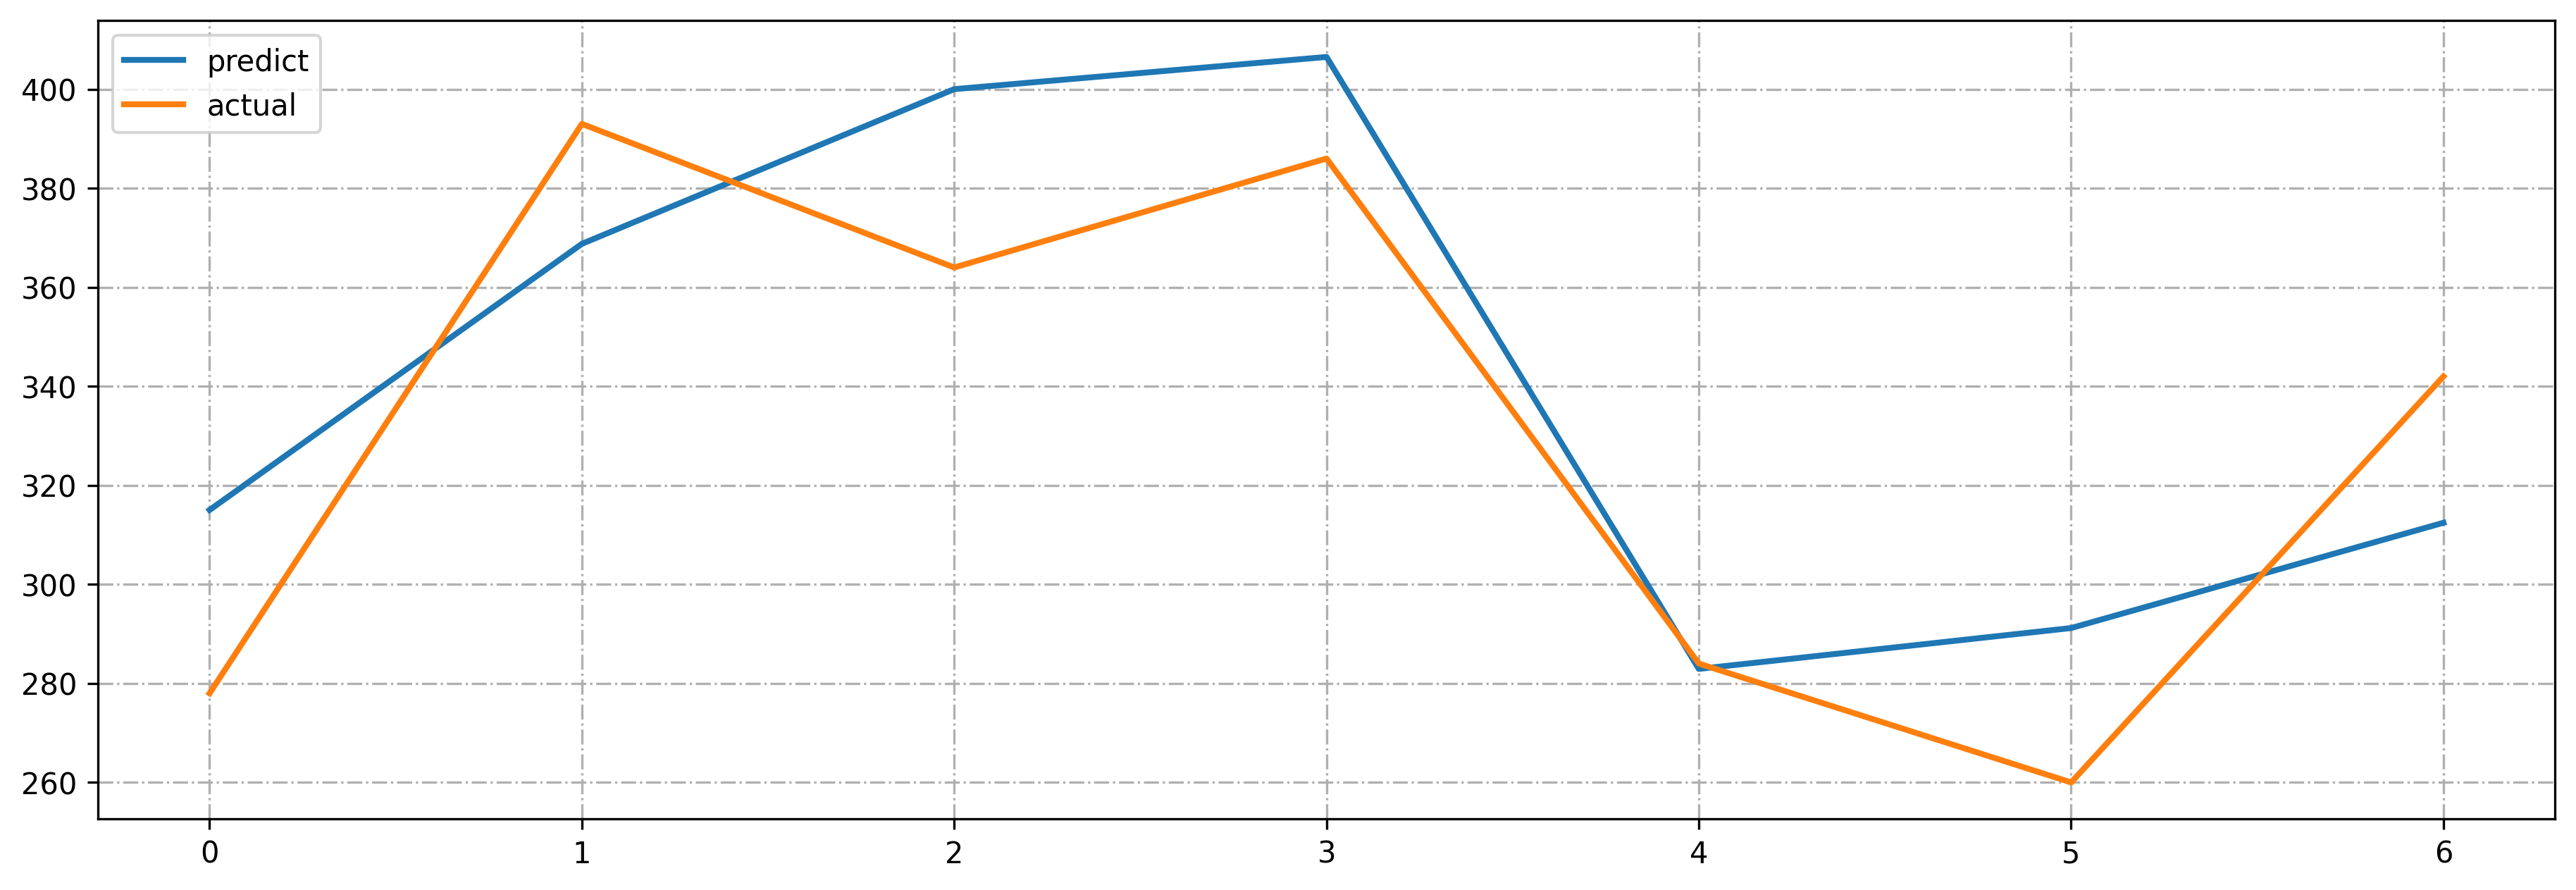

In [1019]:
# Prediction of test dataset
predict1 = result.tail(7).yhat.values
actual1 = df.tail(7).DAILY_ORDERS.values
x = [x for x in range(7)]
fig, ax = plt.subplots(figsize=(15,5),dpi = 300)
ax.plot(x, predict1, linewidth=2.0,label = "predict")
ax.plot(x, actual1, linewidth=2.0,label = "actual")
ax.legend(loc=2);
plt.grid(linestyle='-.')
plt.show()

In [1020]:
# Accuracy of Prophet model
error1 = 0
summery1 = 0
for i in range(7):
    error1 += abs(predict1[i] - actual1[i])
    summery1 += actual1[i]
acc1 = 1 - error1/summery1
print('Accuracy of Prophet model: ',acc1)

Accuracy of Prophet model:  0.9221560612620588


### 5.2  Predictions  of LSTM

In [1021]:
data_lstm = pd.DataFrame({
       'TIMESTAMP': df.TIMESTAMP,
       'DAILY_ORDERS': df.DAILY_ORDERS,
   })
x, y = build_train(data_lstm, n_in, n_out)
x_train, y_train, x_val, y_val = split_data(x, y, n_val)
model = build_lstm(n_in, 1)
model = model_fit(x_train, y_train, x_val, y_val, 1)
predict = model.predict(x_val)

Train on 41 samples, validate on 1 samples
Epoch 1/300
41/41 [==============================] - 4s 91ms/step - loss: 324.8410 - val_loss: 341.9275
Epoch 2/300
41/41 [==============================] - 0s 461us/step - loss: 319.6617 - val_loss: 334.9625
Epoch 3/300
41/41 [==============================] - 0s 438us/step - loss: 316.3263 - val_loss: 329.0971
Epoch 4/300
41/41 [==============================] - 0s 438us/step - loss: 315.2260 - val_loss: 324.1407
Epoch 5/300
41/41 [==============================] - 0s 413us/step - loss: 309.7949 - val_loss: 320.0596
Epoch 6/300
41/41 [==============================] - 0s 414us/step - loss: 309.0350 - val_loss: 316.4483
Epoch 7/300
41/41 [==============================] - 0s 364us/step - loss: 307.7592 - val_loss: 313.0268
Epoch 8/300
41/41 [==============================] - 0s 388us/step - loss: 302.5689 - val_loss: 309.7834
Epoch 9/300
41/41 [==============================] - 0s 438us/step - loss: 300.4905 - val_loss: 306.7763
Epoch 10/300


Epoch 78/300
41/41 [==============================] - 0s 365us/step - loss: 122.9241 - val_loss: 98.9632
Epoch 79/300
41/41 [==============================] - 0s 389us/step - loss: 116.8949 - val_loss: 97.8158
Epoch 80/300
41/41 [==============================] - 0s 365us/step - loss: 125.7111 - val_loss: 96.7261
Epoch 81/300
41/41 [==============================] - 0s 366us/step - loss: 127.7648 - val_loss: 95.5358
Epoch 82/300
41/41 [==============================] - 0s 365us/step - loss: 100.7242 - val_loss: 94.2672
Epoch 83/300
41/41 [==============================] - 0s 341us/step - loss: 111.1634 - val_loss: 92.9818
Epoch 84/300
41/41 [==============================] - 0s 366us/step - loss: 97.2103 - val_loss: 91.3961
Epoch 85/300
41/41 [==============================] - 0s 340us/step - loss: 110.0212 - val_loss: 89.7093
Epoch 86/300
41/41 [==============================] - 0s 365us/step - loss: 115.0100 - val_loss: 87.8198
Epoch 87/300
41/41 [==============================] - 0s

41/41 [==============================] - 0s 364us/step - loss: 79.2992 - val_loss: 34.6736
Epoch 157/300
41/41 [==============================] - 0s 341us/step - loss: 86.5010 - val_loss: 34.8464
Epoch 158/300
41/41 [==============================] - 0s 365us/step - loss: 75.6471 - val_loss: 35.1756
Epoch 159/300
41/41 [==============================] - 0s 341us/step - loss: 62.2262 - val_loss: 35.5985
Epoch 160/300
41/41 [==============================] - 0s 342us/step - loss: 75.8321 - val_loss: 35.5830
Epoch 161/300
41/41 [==============================] - 0s 341us/step - loss: 67.3102 - val_loss: 35.3542
Epoch 162/300
41/41 [==============================] - 0s 366us/step - loss: 76.1690 - val_loss: 35.1113
Epoch 163/300
41/41 [==============================] - 0s 342us/step - loss: 75.8014 - val_loss: 35.3119
Epoch 164/300
41/41 [==============================] - 0s 340us/step - loss: 66.5530 - val_loss: 34.6173
Epoch 165/300
41/41 [==============================] - 0s 341us/step 

Epoch 234/300
41/41 [==============================] - 0s 389us/step - loss: 64.8967 - val_loss: 35.6260
Epoch 235/300
41/41 [==============================] - 0s 365us/step - loss: 81.8262 - val_loss: 36.0173
Epoch 236/300
41/41 [==============================] - 0s 341us/step - loss: 83.2925 - val_loss: 36.4461
Epoch 237/300
41/41 [==============================] - 0s 365us/step - loss: 57.1770 - val_loss: 36.7998
Epoch 238/300
41/41 [==============================] - 0s 342us/step - loss: 58.8631 - val_loss: 37.1339
Epoch 239/300
41/41 [==============================] - 0s 341us/step - loss: 67.4609 - val_loss: 37.4759
Epoch 240/300
41/41 [==============================] - 0s 364us/step - loss: 64.3200 - val_loss: 37.7295
Epoch 241/300
41/41 [==============================] - 0s 365us/step - loss: 70.9813 - val_loss: 37.7790
Epoch 242/300
41/41 [==============================] - 0s 365us/step - loss: 71.6782 - val_loss: 37.7640
Epoch 243/300
41/41 [==============================] - 

In [1022]:
predict2= predict[0]
predict2

array([298.63333, 326.59348, 390.25455, 384.0996 , 370.07666, 274.80197,
       297.07126], dtype=float32)

In [1023]:
actual2=y_val[0]
actual2

array([278., 393., 364., 386., 284., 260., 342.])

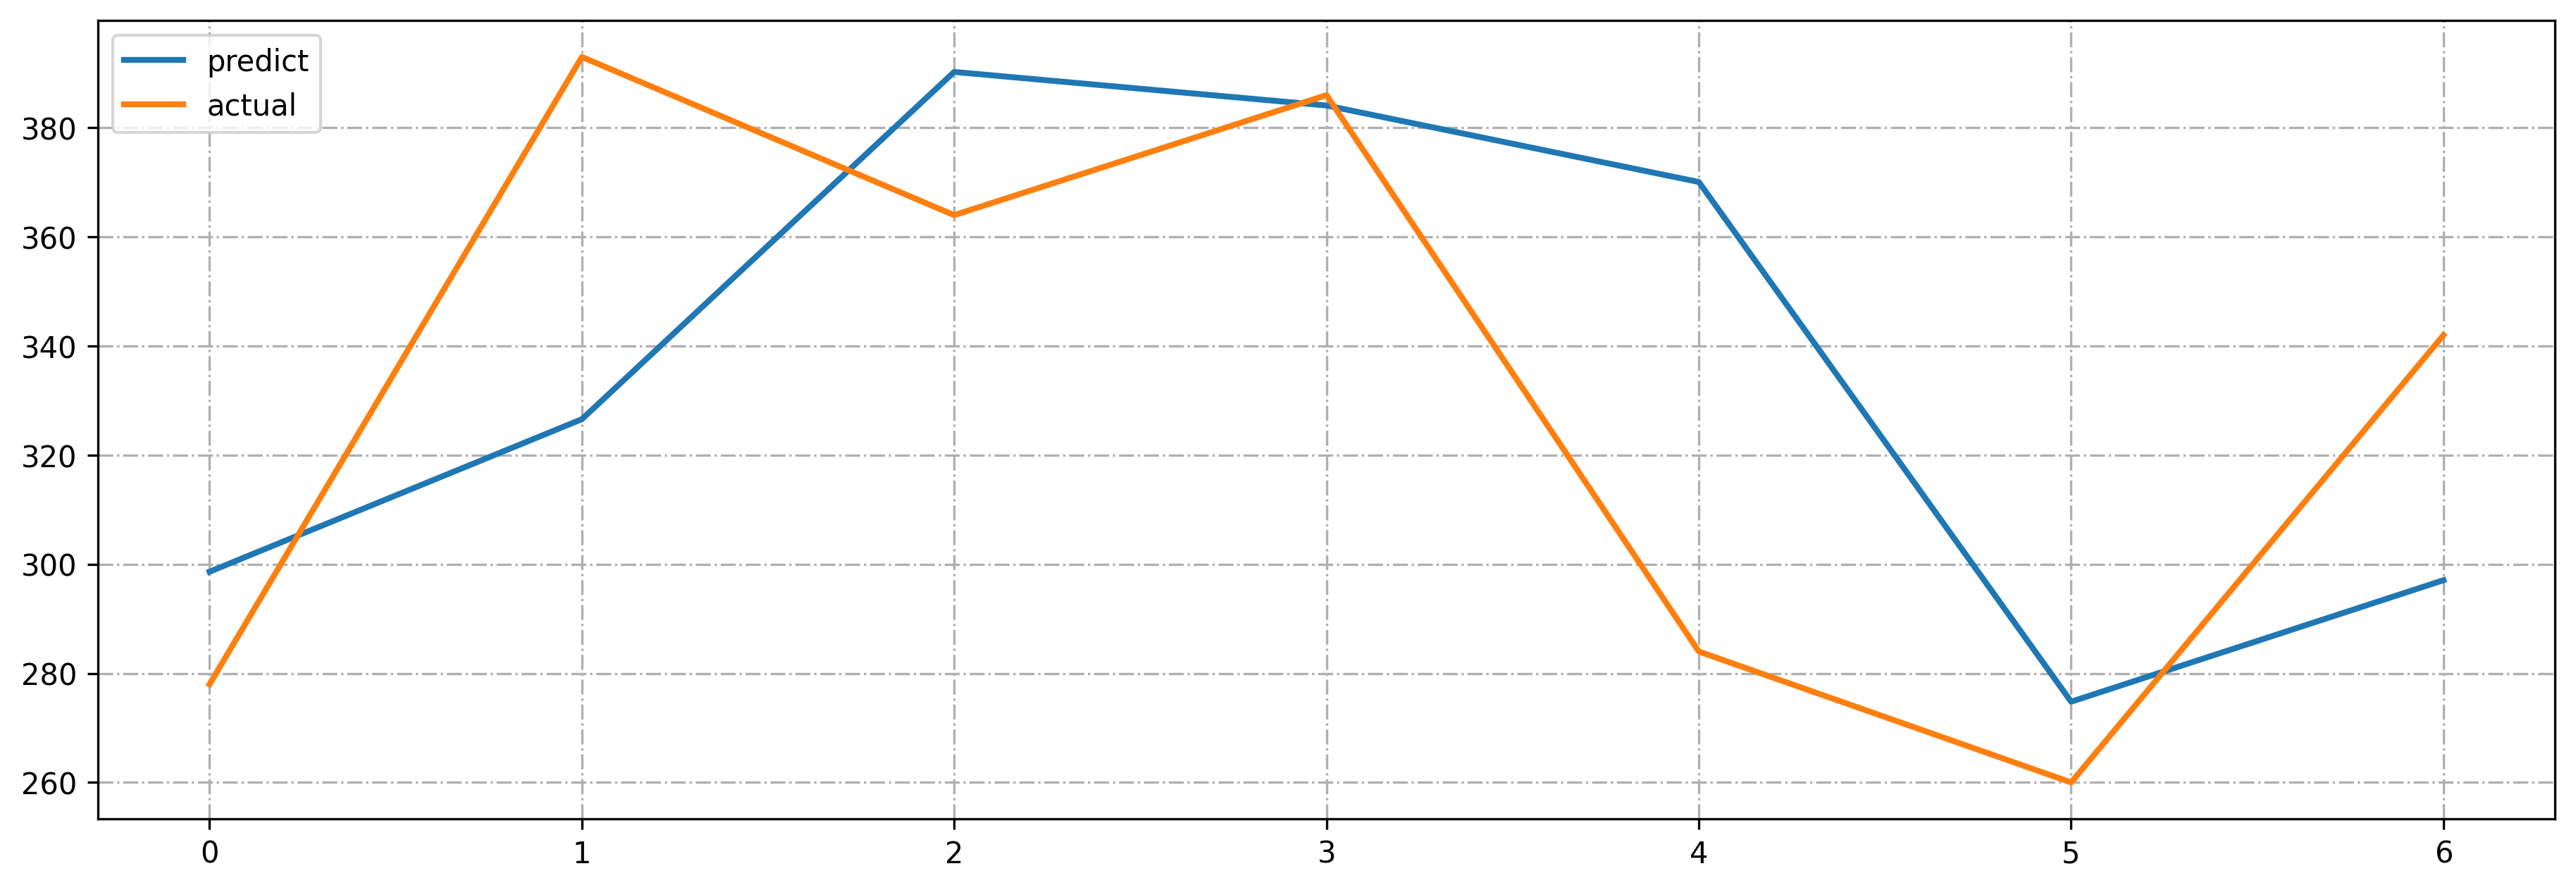

In [1024]:
x = [x for x in range(7)]
fig, ax = plt.subplots(figsize=(15,5),dpi = 300)
ax.plot(x, predict2, linewidth=2.0,label = "predict")
ax.plot(x, actual2, linewidth=2.0,label = "actual")
ax.legend(loc=2);
plt.grid(linestyle='-.')
plt.show()

In [1025]:
#ACC
error2 = 0
summery2 = 0
for i in range(7):
    error2 += abs(predict2[i] - actual2[i])
    summery2 += actual2[i]
acc2 = 1 - error2/summery2
acc2

0.8868651206120299

## **6. Result Comparison and Discussion** 

In [1026]:
result={'Models':['Prophet','LSTM'],
       'Accuracy':[acc1,acc2]}
result= DataFrame(result)
result

,Models,Accuracy
0,Prophet,0.922156
1,LSTM,0.886865


In the result, the accuracy of Prophet is higher than that of LSTM. Prophet model is a little bit better in this case. From the above charts, we can see that the Prophet model can better fit the weekly change of orders.  